In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

### Loading and pre-processing the data

In [2]:
Syn_weather = pd.read_csv('weather_data_2sites-1.csv',parse_dates=['timestamp'],
             infer_datetime_format='%yyyy-%m-%dd %H:%M:%S',skiprows=[1]).drop(columns =['temperature_site2','humidity_site2','Unnamed: 0'])

Syn_weather['day-minutes'] =  Syn_weather['timestamp'].dt.hour * 60 +  Syn_weather['timestamp'].dt.minute
Syn_weather['day-of-the-week'] =  Syn_weather['timestamp'].dt.dayofweek
Syn_weather['previous-temperature'] =  Syn_weather['temperature_site1'].shift()

Syn_weather.drop(columns ='timestamp', inplace=True)
Syn_weather.rename(columns={'temperature_site1':'temperature','humidity_site1':'humidity'},inplace=True)
Syn_weather.index =  Syn_weather.index+1

Syn_weather.loc[1,'previous-temperature']= Syn_weather.loc[1,'temperature'] # setting the first previous-temperature value to the temperature in its row otherwise,
                                                        #it would take 'NaN' value, which will raise an error during the model training.

print( Syn_weather)

      temperature  humidity  day-minutes  day-of-the-week  \
1            21.0      68.0           30                3   
2            20.0      73.0           60                3   
3            20.0      73.0           90                3   
4            20.0      73.0          120                3   
5            20.0      70.0          150                3   
...           ...       ...          ...              ...   
5775         28.0      84.0           60                4   
5776         28.0      84.0           90                4   
5777         28.0      84.0          120                4   
5778         28.0      84.0          150                4   
5779         28.0      84.0          180                4   

      previous-temperature  
1                     21.0  
2                     21.0  
3                     20.0  
4                     20.0  
5                     20.0  
...                    ...  
5775                  28.0  
5776                  28.0  
5777  

## Regression

In [3]:
import pandas as pd # data structure and the operations
import numpy as np # arrays and the operations

import sklearn.linear_model as skl_lm # for regression
from sklearn.model_selection import train_test_split # splitting data into test,train sets

from sklearn.metrics import mean_squared_error # for metrics

import matplotlib.pyplot as plt # plotting library

import seaborn as sns # another plotting library



In [4]:
X =  Syn_weather[['humidity',	'day-minutes','day-of-the-week','previous-temperature']]# Preparing the Dependent and Independent Variables
y =  Syn_weather.temperature


## Linear regression

> Making test, train sets of the data and, fitting the model 

In [5]:
M1 = skl_lm.LinearRegression() # defining a Regression model
X_train,X_test,y_train,y_test =  train_test_split(X,y,test_size =1/3,random_state=5) # test, train sets are split from the original data

M1.fit(X_train,y_train) # Fitting the model to the train sets

print(M1.coef_)
print(M1.intercept_)

[-1.52052587e-02 -4.70626721e-04 -7.08096125e-03  9.69701851e-01]
1.9119579822386612


> Predicting X_test  using the model M1 and calculating RMSE

In [6]:
m1_pred=M1.predict(X_test)
rmse = mean_squared_error(y_test,m1_pred,squared=False) # if squared is 'True' it gives MSE or else it gives RMSE
print("RMSE (M1) : %.3f" %rmse)

RMSE (M1) : 0.924


In [15]:
M1.

True

## Cross Validation 

In [7]:
from sklearn.model_selection import KFold # Splitting the data into K folds used for cv (Cross Validation)
from sklearn.model_selection import cross_val_score # For calculating the RMSE
from sklearn.model_selection import cross_val_predict # For predictions using cv


In [8]:
X =  Syn_weather[['humidity',	'day-minutes','day-of-the-week','previous-temperature']]# Independent Variables
y =  Syn_weather.temperature # Dependent Variable 

kfold = KFold(n_splits=10,random_state=5,shuffle=True) # 10 fold splitting of the input data 

M2 = skl_lm.LinearRegression()

results = cross_val_score(M2,X,y,cv=kfold,scoring='neg_mean_squared_error') # Calculating the RMSE of Cross Validation method
rmse = np.mean(np.sqrt(np.abs(results))) # Converting MSE to RMSE
print("RMSE (M2) : %.3f" %rmse)

RMSE (M2) : 0.938


## Plotting

<AxesSubplot:title={'center':'Model M2'}, xlabel='Observation No. (Index)', ylabel='Temperature'>

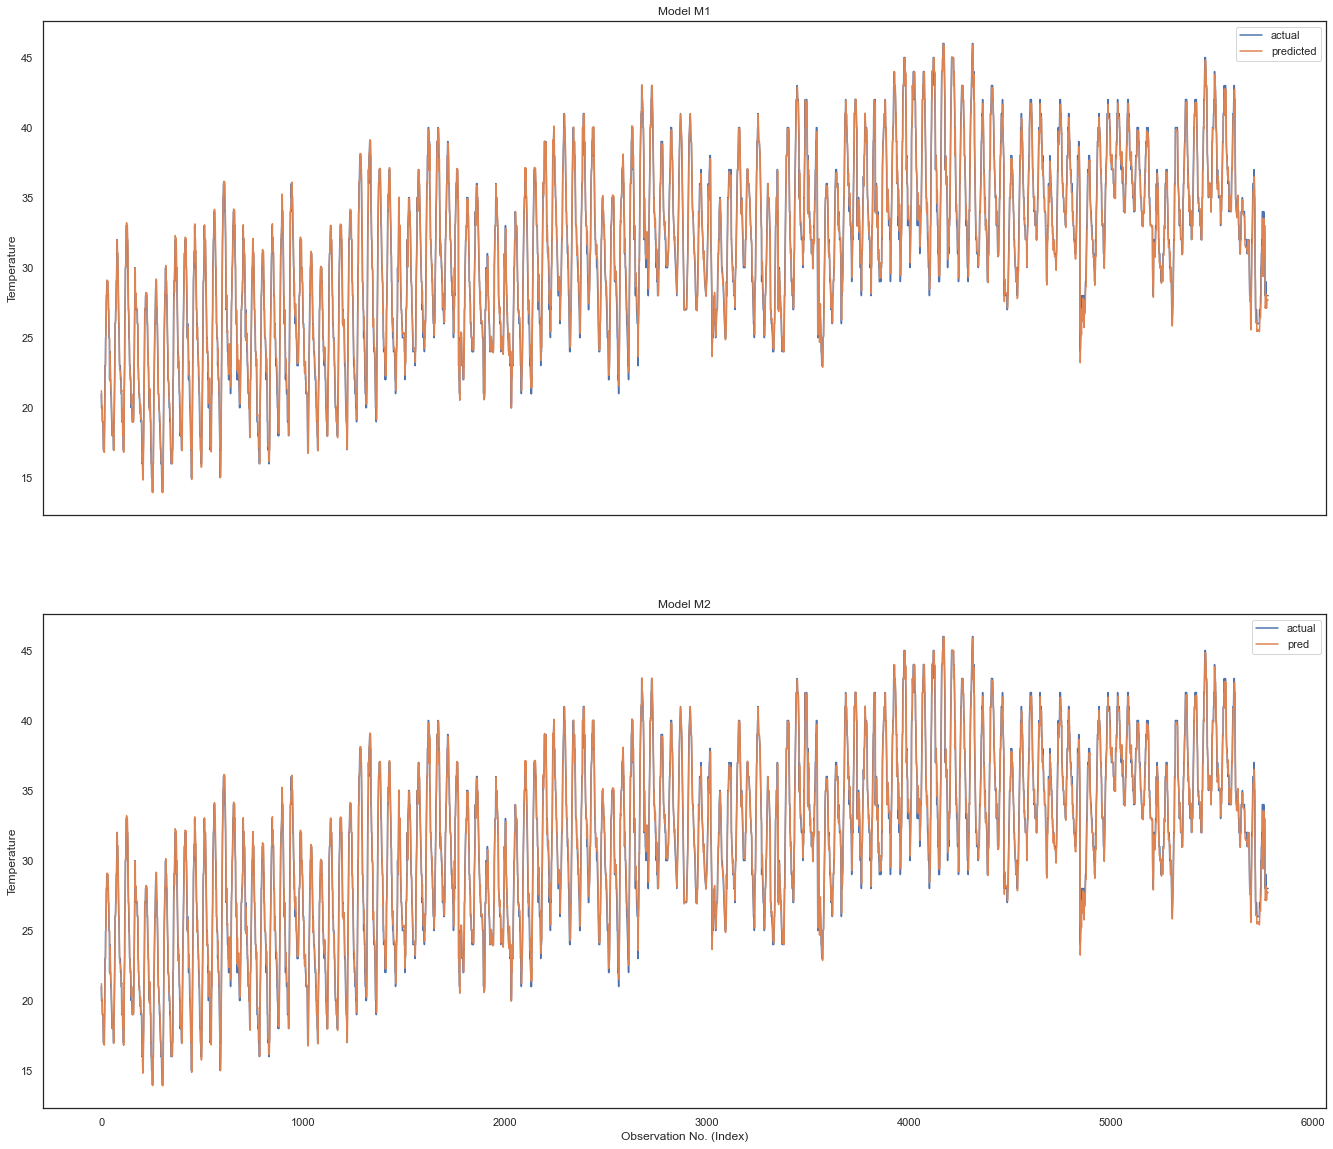

In [12]:
m1_pred=M1.predict(X)
pred_M1 = pd.DataFrame({'actual':y, 'predicted':m1_pred})

m2_pred = cross_val_predict(M2,X,y,cv=kfold) # Predicting using Crosss Validation method
pred_M2 = pd.DataFrame({'actual':y,'pred':m2_pred})

fig, axes = plt.subplots(2,1,figsize=(23,20))

pred_M1.plot(ax = axes[0],subplots=False,ylabel = 'Temperature',sharex=True,title = 'Model M1')

pred_M2.plot(ax = axes[1],subplots=False,ylabel='Temperature',xlabel ='Observation No. (Index)',title = 'Model M2')

> * Since, both M1 and M2 have an RMSE of <1, we expect a good fit of values
> * Considering the RMSE values of M! and M2 only differ by ~0.01, we expect both the models to be very similar in performance
> * Both M1 and M2 models are very accurate and precise and this can be seen by the plots. 
> * The plots shows that, in this case the Cross Validation method has very minimal improvements over regular Linear regression with test, train split.

## Corr coeff

In [10]:
corr =  Syn_weather.corr()
corr

,temperature,humidity,day-minutes,day-of-the-week,previous-temperature
temperature,1.000000,-0.702853,0.368295,-0.021720,0.988245
humidity,-0.702853,1.000000,-0.352824,0.007783,-0.691608
day-minutes,0.368295,-0.352824,1.000000,-0.000376,0.394892
day-of-the-week,-0.021720,0.007783,-0.000376,1.000000,-0.021230
previous-temperature,0.988245,-0.691608,0.394892,-0.021230,1.000000


### Correlation Matrix

<AxesSubplot:>

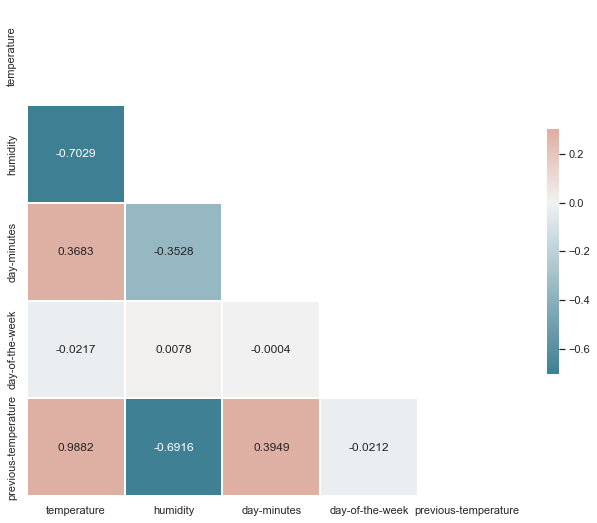

In [11]:
mask = np.triu(np.ones_like(corr,dtype=bool))
sns.set_theme(style='white')
fig,ax = plt.subplots(figsize = (11,9))
cmap = sns.diverging_palette(220, 20, n=200,as_cmap=True)
sns.heatmap(corr,mask=mask,vmax = 0.3,center=0,square=True,fmt = '.4f', annot = True,cmap=cmap,linewidths=2 , cbar_kws={"shrink": .5})

> * The Correlation between temperature and Humidity is very -ve. This tells that as humidity increases the temperature decreases, which is accurate.
> * The 'day-minutes' (basically tells us what time of the day) is +ve correlated to temperature. This is also accurate to the real world.
> * From the correlation plot/ matrix, it's very clear that 'day-of-the-week' has very little effect on temperature and humidity.
> * Previous temperature has a considerate effect on humidity.

In [17]:
import statsmodels.api as sm

In [86]:
X =  Syn_weather[['humidity',	'day-minutes','day-of-the-week','previous-temperature']]# Preparing the Dependent and Independent Variables
x_columns = ['humidity',	'day-minutes','day-of-the-week','previous-temperature']
y =  Syn_weather.temperature
# Syn_weather
def get_stats():
    x = Syn_weather[x_columns]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                                 OLS Regression Results                                
Dep. Variable:            temperature   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.606e+06
Date:                Fri, 12 Nov 2021   Prob (F-statistic):                        0.00
Time:                        14:27:09   Log-Likelihood:                         -7955.5
No. Observations:                5779   AIC:                                  1.592e+04
Df Residuals:                    5775   BIC:                                  1.595e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Dropping p > 0.01

In [28]:
x_columns.remove("day-of-the-week")
get_stats()

                                 OLS Regression Results                                
Dep. Variable:            temperature   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.139e+06
Date:                Fri, 12 Nov 2021   Prob (F-statistic):                        0.00
Time:                        13:56:37   Log-Likelihood:                         -7958.3
No. Observations:                5779   AIC:                                  1.592e+04
Df Residuals:                    5776   BIC:                                  1.594e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [88]:
np.set_printoptions(precision=5)
x = Syn_weather[x_columns]
results = sm.OLS(y, x).fit()

results.summary()
re = results.pvalues
k = re[re == re.max()].index.array
k
# pd.Index(results.pvalues).get_loc(results.pvalues.max())
results.aic
# results.

15919.002804710814

In [93]:
X =  Syn_weather[['humidity',	'day-minutes','day-of-the-week','previous-temperature']]# Preparing the Dependent and Independent Variables
x_columns = ['humidity',	'day-minutes','day-of-the-week','previous-temperature']
y =  Syn_weather.temperature
def stepwise_reg():
    x = Syn_weather[x_columns]
    results = sm.OLS(y, x).fit()
    aic = []
    if len(x_columns) != 2 : 
        re = results.pvalues
        aic.append(results.aic)
        k = re[re == re.max()].index.array
        x_columns.remove(k[0])
        print(results.pvalues,results.aic,x_columns)
        stepwise_reg()
        
        
stepwise_reg()

humidity                2.153968e-05
day-minutes             1.478760e-36
day-of-the-week         1.791124e-02
previous-temperature    0.000000e+00
dtype: float64 15919.002804710814 ['humidity', 'day-minutes', 'previous-temperature']
humidity                1.606500e-04
day-minutes             2.762652e-36
previous-temperature    0.000000e+00
dtype: float64 15922.611981799246 ['day-minutes', 'previous-temperature']


In [43]:
len(x_columns)

3